In [4]:

import os, shutil
from glob import glob
import numpy as np
import pandas as pd
from natsort import natsorted
import seaborn as sns
from tqdm import tqdm, trange
import matplotlib.pyplot as plt


In [5]:
in_dir = "out01_tms_induced_respose/"
in_dir2 = "data_subject_info/"
in_file_name = "HRF_tms_induced_response_common_mask.csv"

out_dir = "out02_one_sample_ttest_and_boxplot_common_mask/"

if not os.path.exists(out_dir):
    os.mkdir(out_dir)
    
complete_df = pd.read_csv(in_dir + in_file_name)
complete_df


,inputfile,subject,site,group,tms_site_response_6mm,tms_site_response_10mm,tms_site_response_14mm,tms_site_response_14-10mm,tms_site_response_10-6mm
0,/Users/jingjiang/Library/CloudStorage/GoogleDr...,1001,L_Fp,NTHC,0.183782,0.223570,0.179095,0.151442,0.234871
1,/Users/jingjiang/Library/CloudStorage/GoogleDr...,1003,L_Fp,NTHC,0.342369,-0.466842,-0.895508,-1.162043,-0.696677
2,/Users/jingjiang/Library/CloudStorage/GoogleDr...,1036,L_Fp,NTHC,-1.276525,-1.059491,-1.074080,-1.083151,-0.997848
3,/Users/jingjiang/Library/CloudStorage/GoogleDr...,1037,L_Fp,NTHC,-0.176526,-0.345498,-0.344236,-0.343451,-0.393490
4,/Users/jingjiang/Library/CloudStorage/GoogleDr...,1038,L_Fp,NTHC,-0.439485,-0.470011,-0.430232,-0.405498,-0.478681
...,...,...,...,...,...,...,...,...,...
793,/Users/jingjiang/Library/CloudStorage/GoogleDr...,2090,R_preSMA,TEHC,0.029287,0.069017,0.084611,0.092588,0.078394
794,/Users/jingjiang/Library/CloudStorage/GoogleDr...,2093,R_preSMA,TEHC,0.049642,0.195048,0.165906,0.150998,0.229367
795,/Users/jingjiang/Library/CloudStorage/GoogleDr...,2102,R_preSMA,TEHC,-1.299271,-0.978081,-0.564916,-0.353553,-0.902272
796,/Users/jingjiang/Library/CloudStorage/GoogleDr...,2105,R_preSMA,TEHC,-0.895282,-0.792240,-0.339950,-0.108574,-0.767919


In [11]:
## boxplot of response (gender by site):

a4_dims = (12, 8)
tms_sites = complete_df['site'].unique()
plot_x_order = ["L_Fp","R_Fp","L_aMFG","R_aMFG","L_pMFG","R_pMFG","R_IFJ","R_FEF","R_M1","R_preSMA","R_IPL"]
colors = [sns.xkcd_rgb["black"]] + sns.color_palette("husl", len(tms_sites)).as_hex()
colors = colors[1::2] + colors[2::2] 

def plot_response(ylabel, pvalue, cohend):

    fig, ax = plt.subplots(figsize=a4_dims, dpi=300)
    
    sns.violinplot(y = ylabel, x = "site", data = complete_df, dodge=False,
                    palette = colors, ax = ax,
                    scale = "width", inner = None)
    
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    for violin in ax.collections:
        bbox = violin.get_paths()[0].get_extents()
        x0, y0, width, height = bbox.bounds
        violin.set_clip_path(plt.Rectangle((x0, y0), width / 2, height, transform=ax.transData))
    
    
    sns.swarmplot(y = ylabel, x = "site", data = complete_df, 
                  #hue = 'gender', 
                  order=plot_x_order,
                  dodge=True, ax = ax, facecolors='none',
                  palette = colors, #plot_kws={'scatter_kws': {'alpha': 0.1}}
                  alpha = .75, size=4)

    sns.boxplot(y = ylabel, x = "site", data = complete_df, #hue = 'gender', 
                order=plot_x_order,
                palette = colors, notch = True, ax = ax)
    
    for i,artist in enumerate(ax.artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        col = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor('None')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i*6,i*6+6):
            line = ax.lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)

    # sns.boxplot(data=df,x="site",y="tms_site_response",dodge=True,showfliers=False,
                # showbox=True,linewidth=0.8,color = "w");
        
    # add annotations:
    locs, _ = plt.xticks()
    y = 3
    for i, x in enumerate(locs):
        ax.text(x-.3, y, "${p}$=" + pvalue[i], ha='left', va='bottom', color='k', size = 10)
        ax.text(x-.3, y+.25, "${d}$=" + cohend[i], ha='left', va='bottom', color='k', size = 10)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.set_xlim([-1, len(tms_sites)])
    ax.set_ylabel("Mean TMS Site Response")
    ax.set_xlabel("TMS Site");

    # Add horizontal red lines indicating mean of violinplot
#     spread = 0.1
#     for i, label in enumerate(ax.get_xticklabels()):
#         tms = label.get_text()
#         mean = np.nanmean(complete_df[complete_df['site']==str(tms)]['tms_site_response_standard'])
#         ax.hlines(mean, i-spread, i+spread, colors='red')
    ax.hlines(0, -1,len(tms_sites), linestyles='dotted', colors='grey')
    
    return fig

In [7]:
## run 1 sample t-test for each roi:
pd.options.mode.chained_assignment = None # avoid the warnning message for assigning values to slices of df.
from scipy.stats import ttest_1samp

def format_table(report):
    report2 = report.copy()
    report2[report.gt(0)] = report2[report.gt(0)].astype(str).apply(lambda x : x.str[:5])
    report2[report.lt(0)] = report2[report.lt(0)].astype(str).apply(lambda x : x.str[:6])
    
    report_pvalue = report2.iloc[1::3,:]
    report_pvalue[report.iloc[1::3,:].le(0.05)] = \
    report_pvalue[report.iloc[1::3,:].le(0.05)].apply(lambda x : x.str[:5]).add('*')

    report_pvalue = report2.iloc[1::3,:]
    report_pvalue[report.iloc[1::3,:].le(0.01)] = \
    report_pvalue[report.iloc[1::3,:].le(0.01)].apply(lambda x : x.str[:5]).add('**')
        
    return report2

test_variables = ['tms_site_response_6mm',
           'tms_site_response_10mm', 'tms_site_response_14mm', 
           'tms_site_response_14-10mm', 'tms_site_response_10-6mm']

row_index = pd.MultiIndex.from_tuples([(i , j) for i in test_variables for j in ['t value', 'p value', "Cohen's d"]])
result = pd.DataFrame(index = row_index, columns = plot_x_order)

# statistical tests for each roi and roi setting:
for var in test_variables:
    for tms in plot_x_order:
        value = complete_df.loc[(complete_df['site']==tms) & (~complete_df[var].isna()), var]
        # add () & () to multiple conditions.
        t, p = ttest_1samp(value, popmean=0)
        cohend = value.mean() / value.std()
        
        result.loc[(var, 't value'), tms] = t
        result.loc[(var, 'p value'), tms] = p
        result.loc[(var, "Cohen's d"), tms] = cohend

result = format_table(result)
# save results separately for each roi setting:
for var in test_variables:
    result.loc[(var, ['t value', 'p value', "Cohen's d"]), :].to_csv(out_dir + 'response_' + var + '.csv')

result

L_Fp    R_Fp  L_aMFG  R_aMFG  L_pMFG  \
tms_site_response_6mm     t value     -2.569  -0.719  -0.698  -0.655  -1.637   
                          p value     0.012*   0.474   0.487   0.513   0.105   
                          Cohen's d   -0.318  -0.086  -0.079  -0.073  -0.183   
tms_site_response_10mm    t value     -3.021  -0.846  -0.481  -0.713  -2.104   
                          p value    0.003**   0.400   0.631   0.477  0.038*   
                          Cohen's d   -0.374  -0.101  -0.054  -0.079  -0.235   
tms_site_response_14mm    t value     -3.140  -0.873  -0.316  -0.847  -2.363   
                          p value    0.002**   0.385   0.752   0.399  0.020*   
                          Cohen's d   -0.389  -0.105  -0.036  -0.094  -0.264   
tms_site_response_14-10mm t value     -3.027  -0.880  -0.223  -0.923  -2.455   
                          p value    0.003**   0.381   0.823   0.358  0.016*   
                          Cohen's d   -0.375  -0.105  -0.025  -0.103  -0.274   
tms_site_response_10-6mm  t value     -3.091  -0.884  -0.437  -0.722  -2.189   
                          p value    0.002**   0.379   0.662   0.471  0.031*   
                          Cohen's d   -0.383  -0.106  -0.049  -0.080  -0.244   

                                     R_pMFG    R_IFJ    R_FEF     R_M1  \
tms_site_response_6mm     t value    -1.134   -2.488   -1.199   -1.843   
                          p value     0.259   0.015*    0.234    0.068   
                          Cohen's d  -0.127   -0.285   -0.135   -0.207   
tms_site_response_10mm    t value    -1.661   -2.606   -2.065   -2.244   
                          p value     0.100   0.011*   0.042*   0.027*   
                          Cohen's d  -0.186   -0.298   -0.233   -0.252   
tms_site_response_14mm    t value    -1.994   -2.868   -2.610   -2.680   
                          p value    0.049*  0.005**   0.010*  0.008**   
                          Cohen's d  -0.224   -0.328   -0.295   -0.301   
tms_site_response_14-10mm t value    -2.158   -2.992   -2.918   -2.963   
                          p value    0.033*  0.003**  0.004**  0.004**   
                          Cohen's d  -0.242   -0.343   -0.330   -0.333   
tms_site_response_10-6mm  t value    -1.779   -2.609   -2.318   -2.350   
                          p value     0.079   0.010*   0.023*   0.021*   
                          Cohen's d  -0.200   -0.299   -0.262   -0.264   

                                    R_preSMA  R_IPL  
tms_site_response_6mm     t value     -0.898  1.250  
                          p value      0.372  0.216  
                          Cohen's d   -0.112  0.175  
tms_site_response_10mm    t value     -0.946  1.010  
                          p value      0.347  0.317  
                          Cohen's d   -0.118  0.141  
tms_site_response_14mm    t value     -1.219  0.795  
                          p value      0.227  0.430  
                          Cohen's d   -0.152  0.111  
tms_site_response_14-10mm t value     -1.372  0.597  
                          p value      0.174  0.552  
                          Cohen's d   -0.171  0.083  
tms_site_response_10-6mm  t value     -0.950  0.889  
                          p value      0.345  0.377  
                          Cohen's d   -0.118  0.124

tms_site_response_6mm


/Users/jingjiang/miniconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jingjiang/miniconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


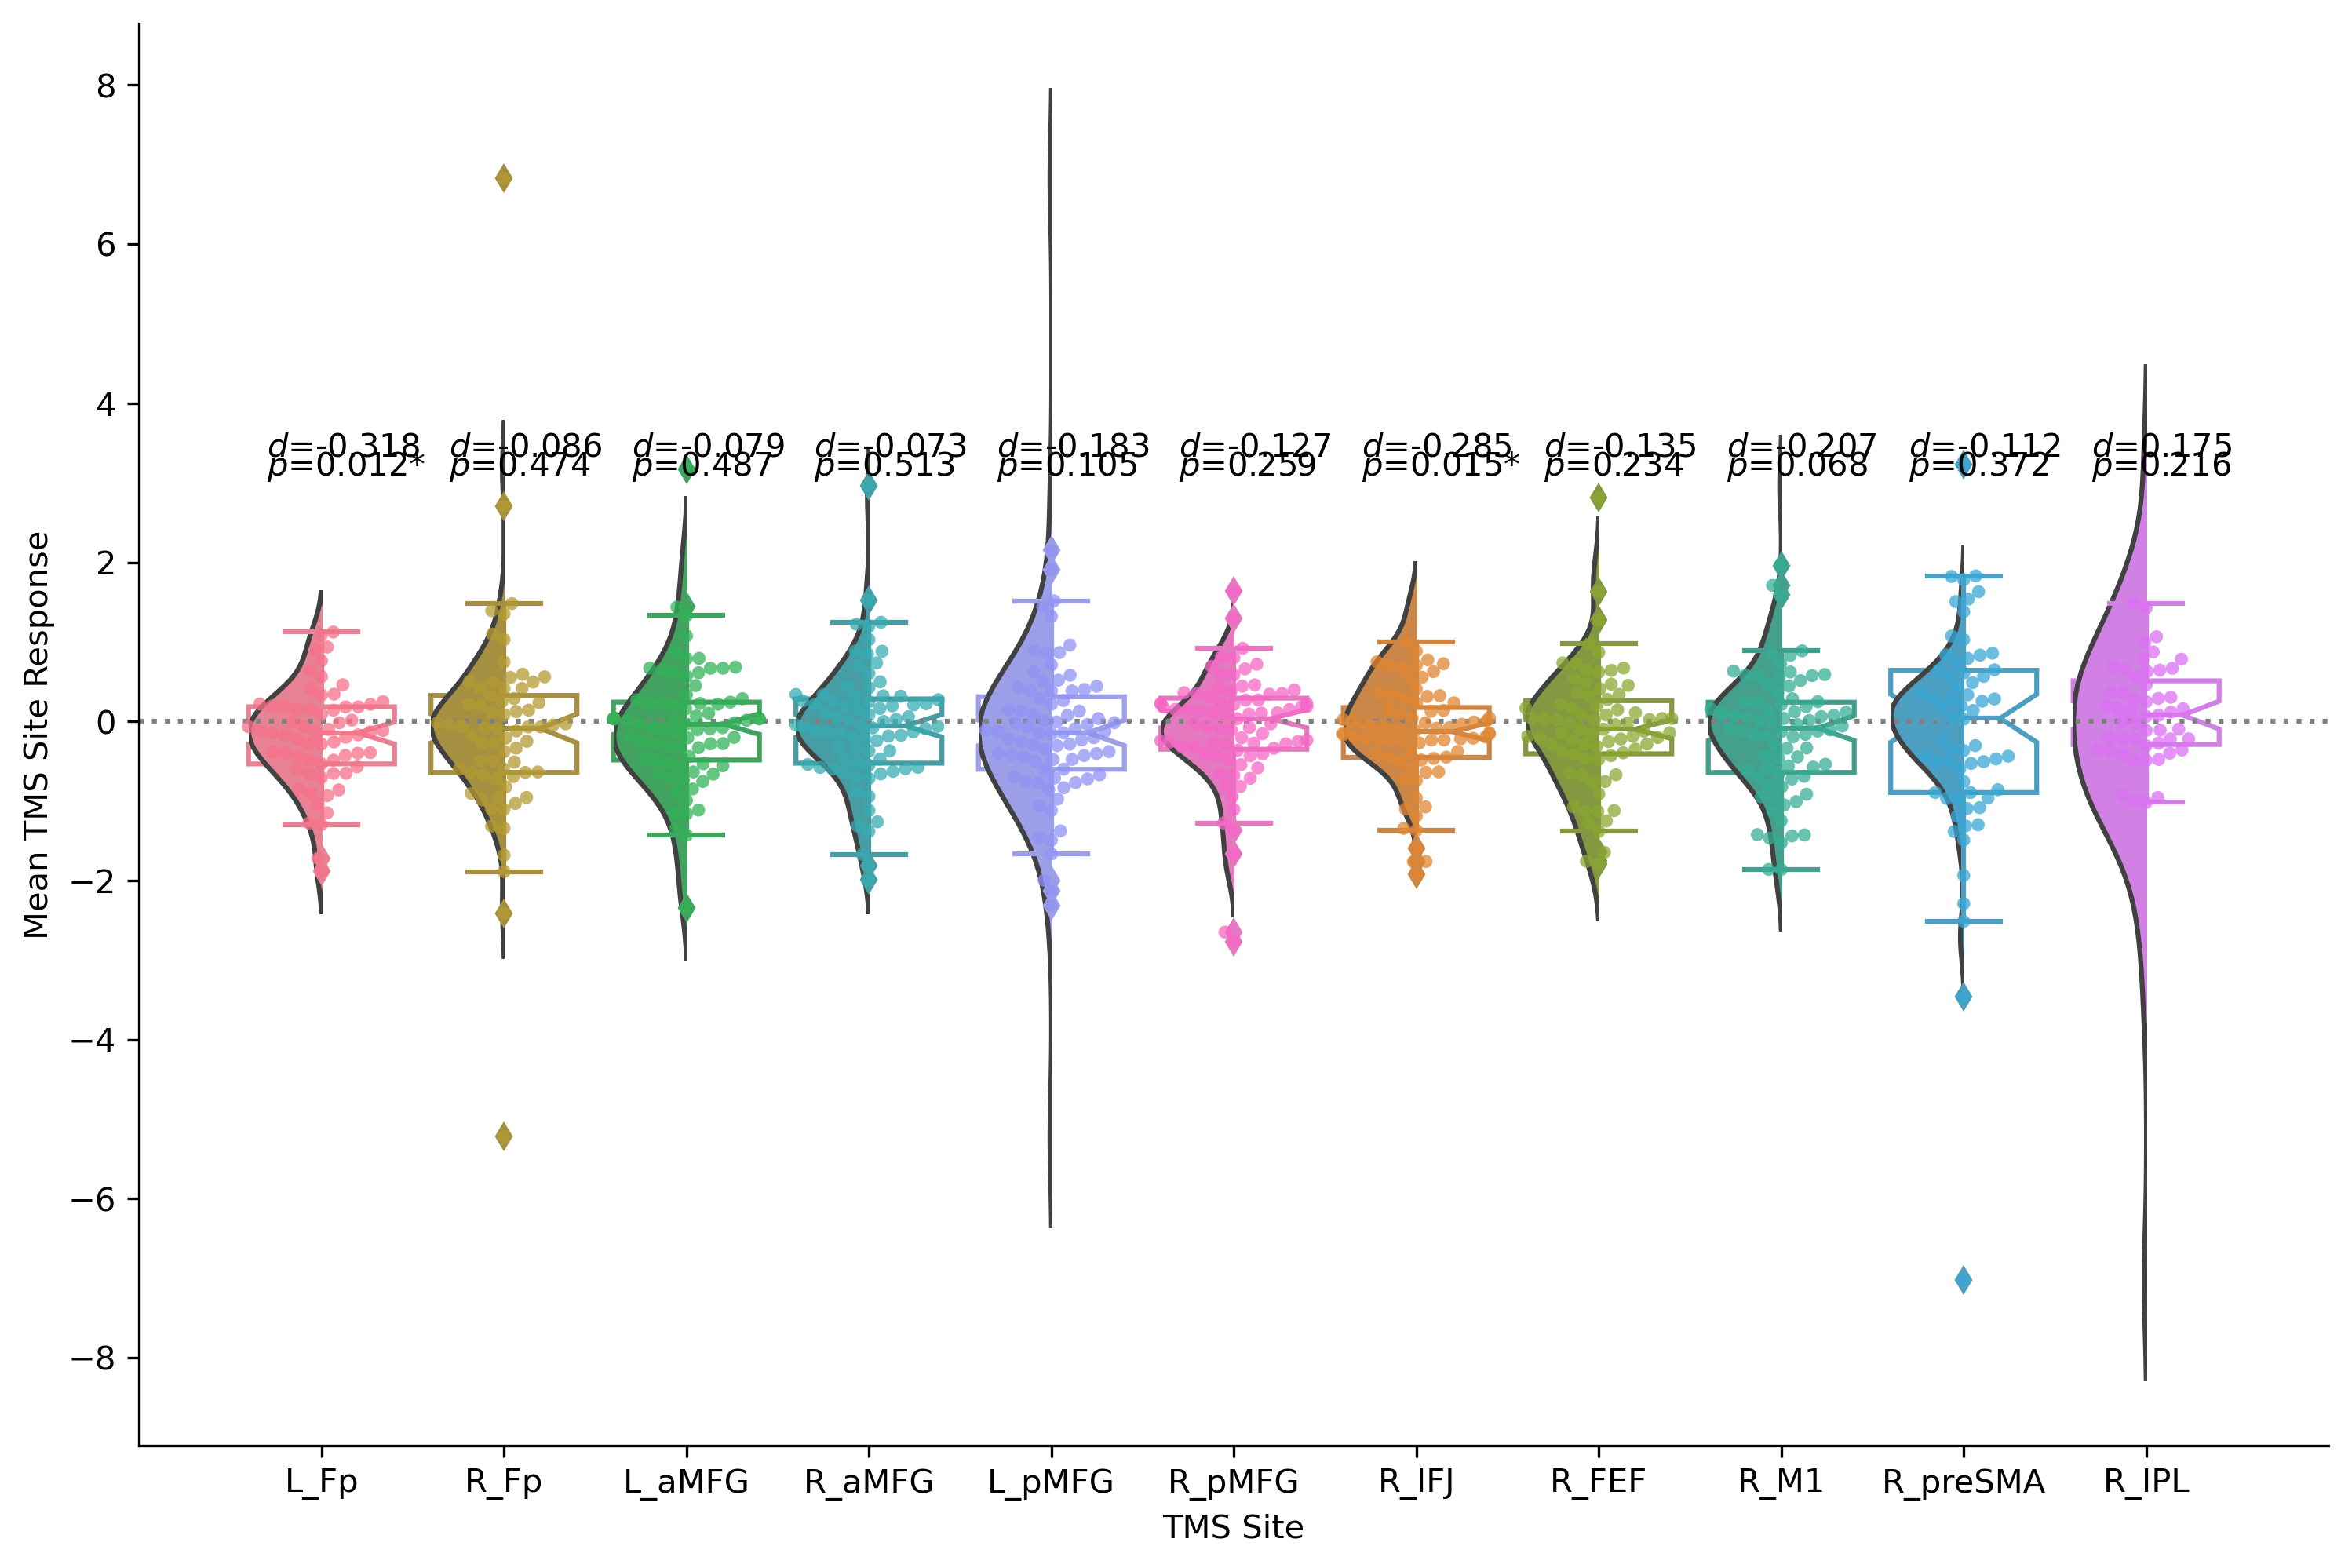

tms_site_response_10mm


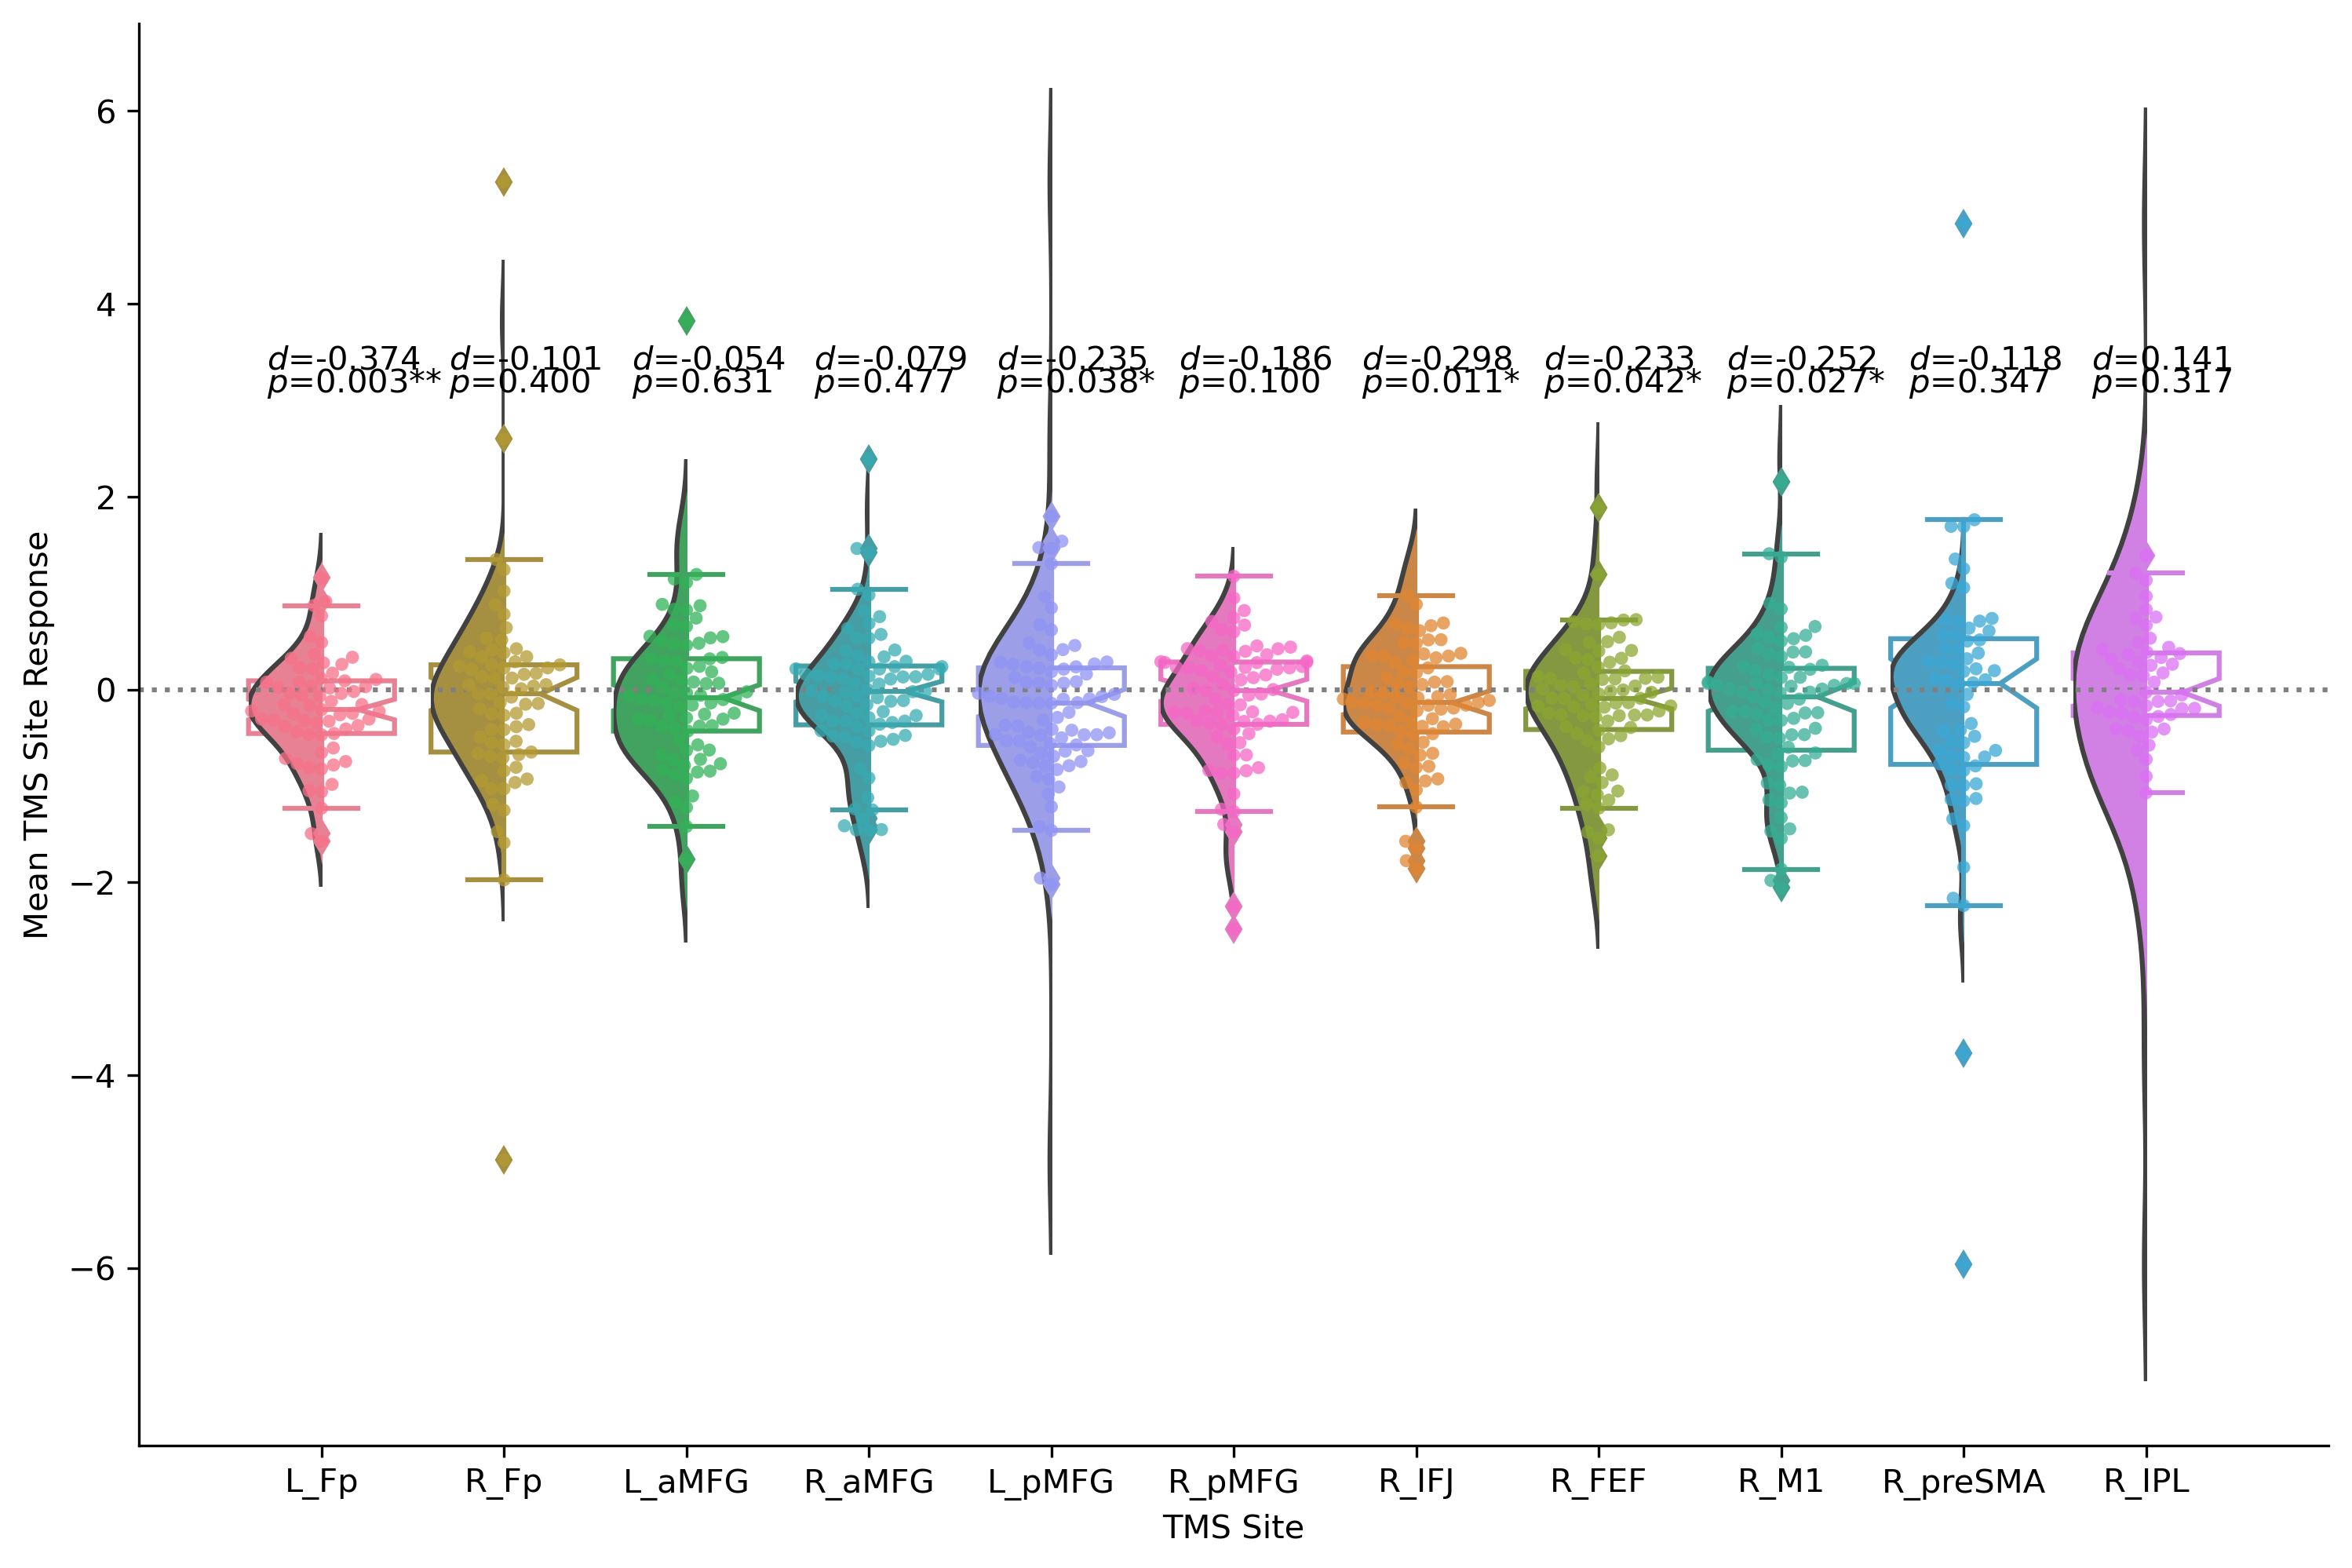

tms_site_response_14mm


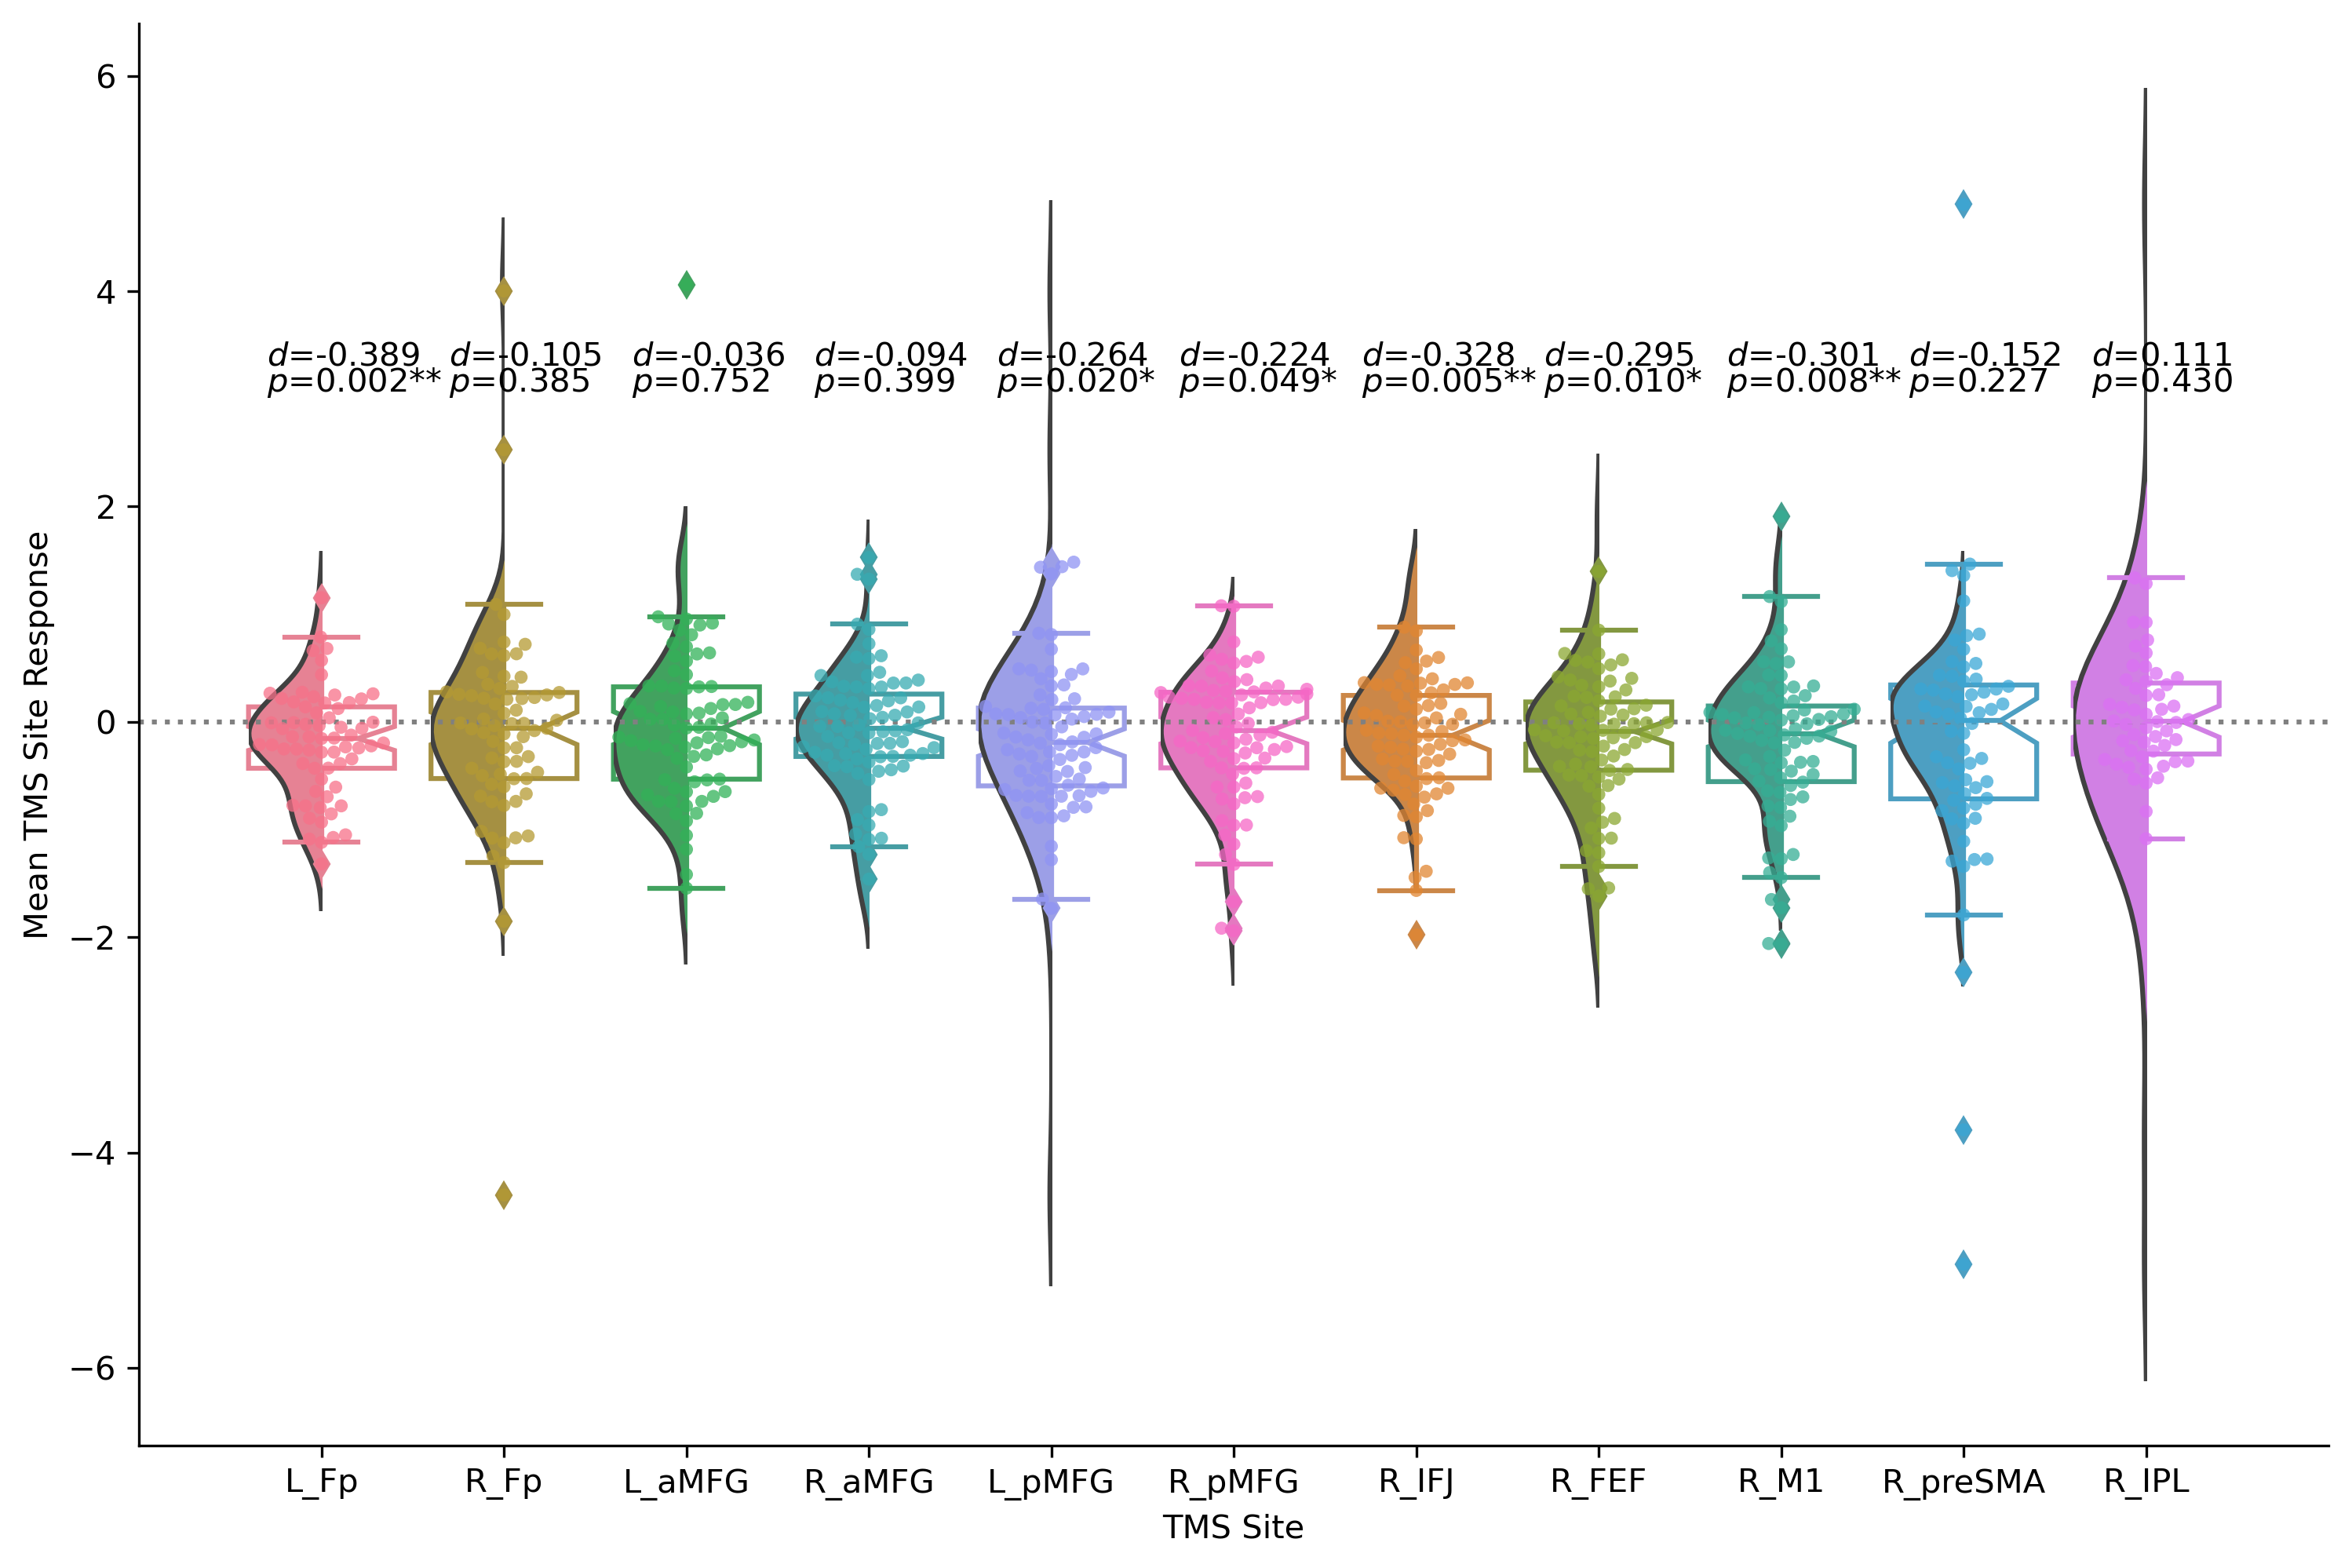

tms_site_response_14-10mm


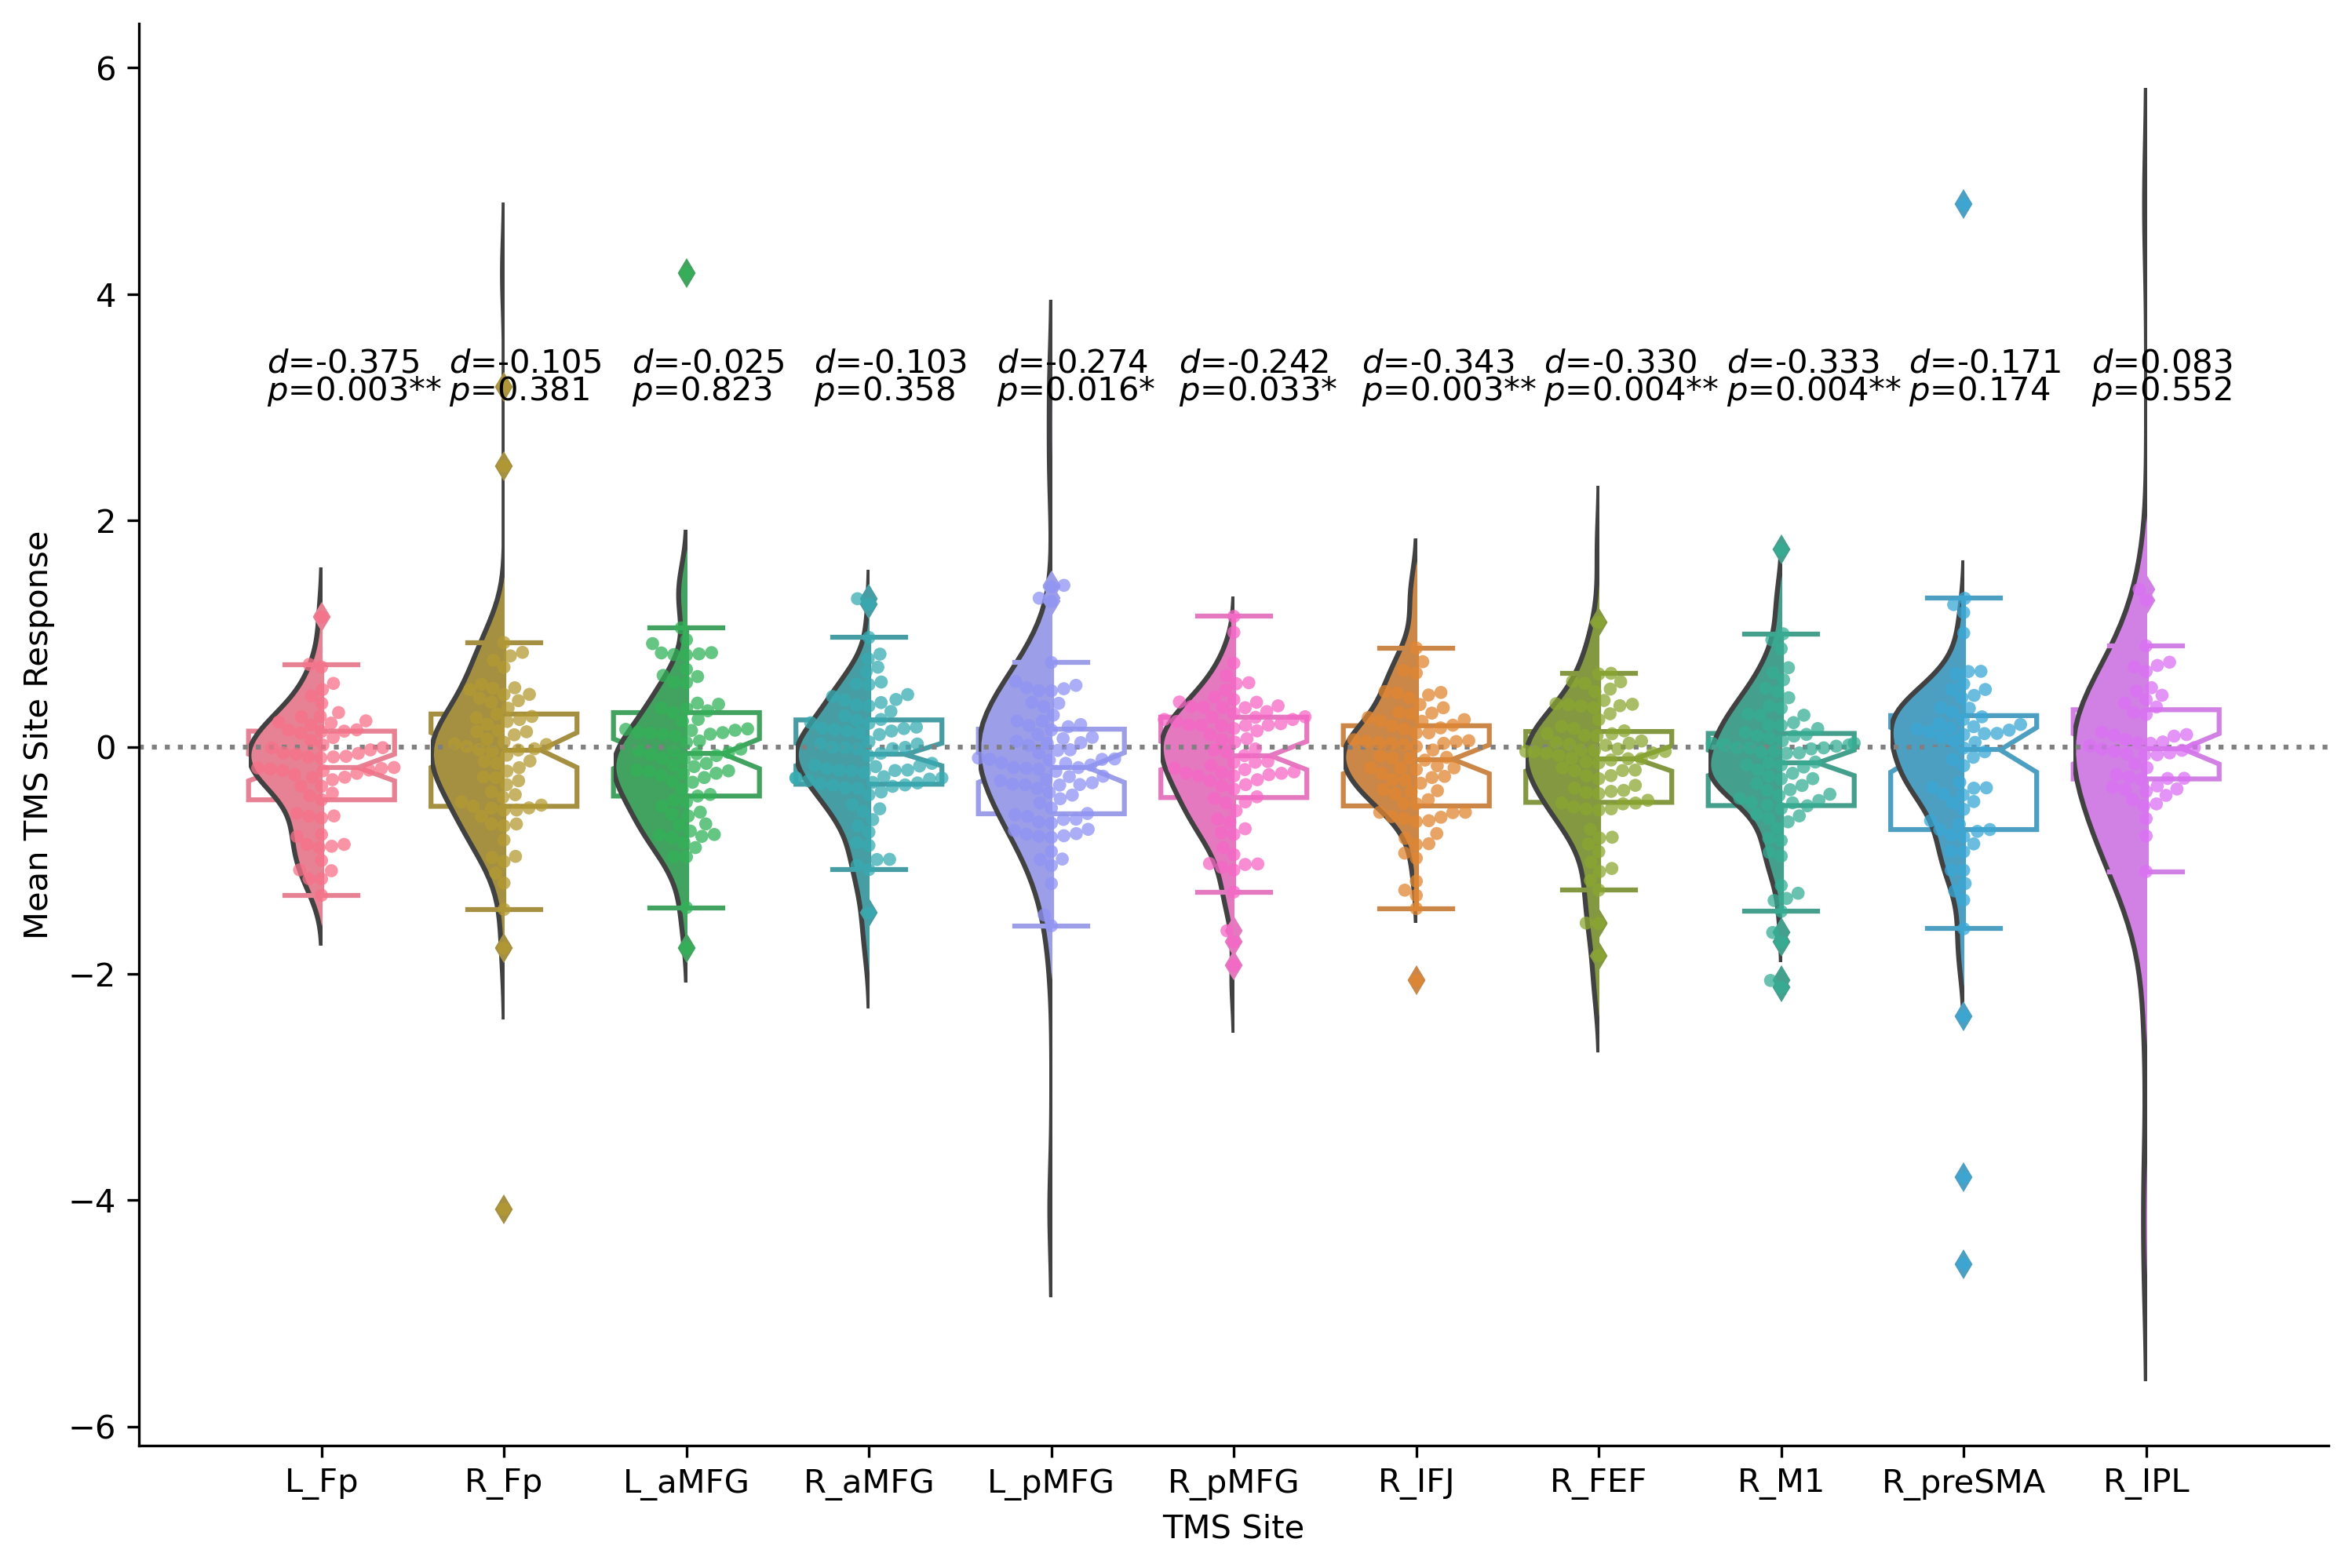

tms_site_response_10-6mm


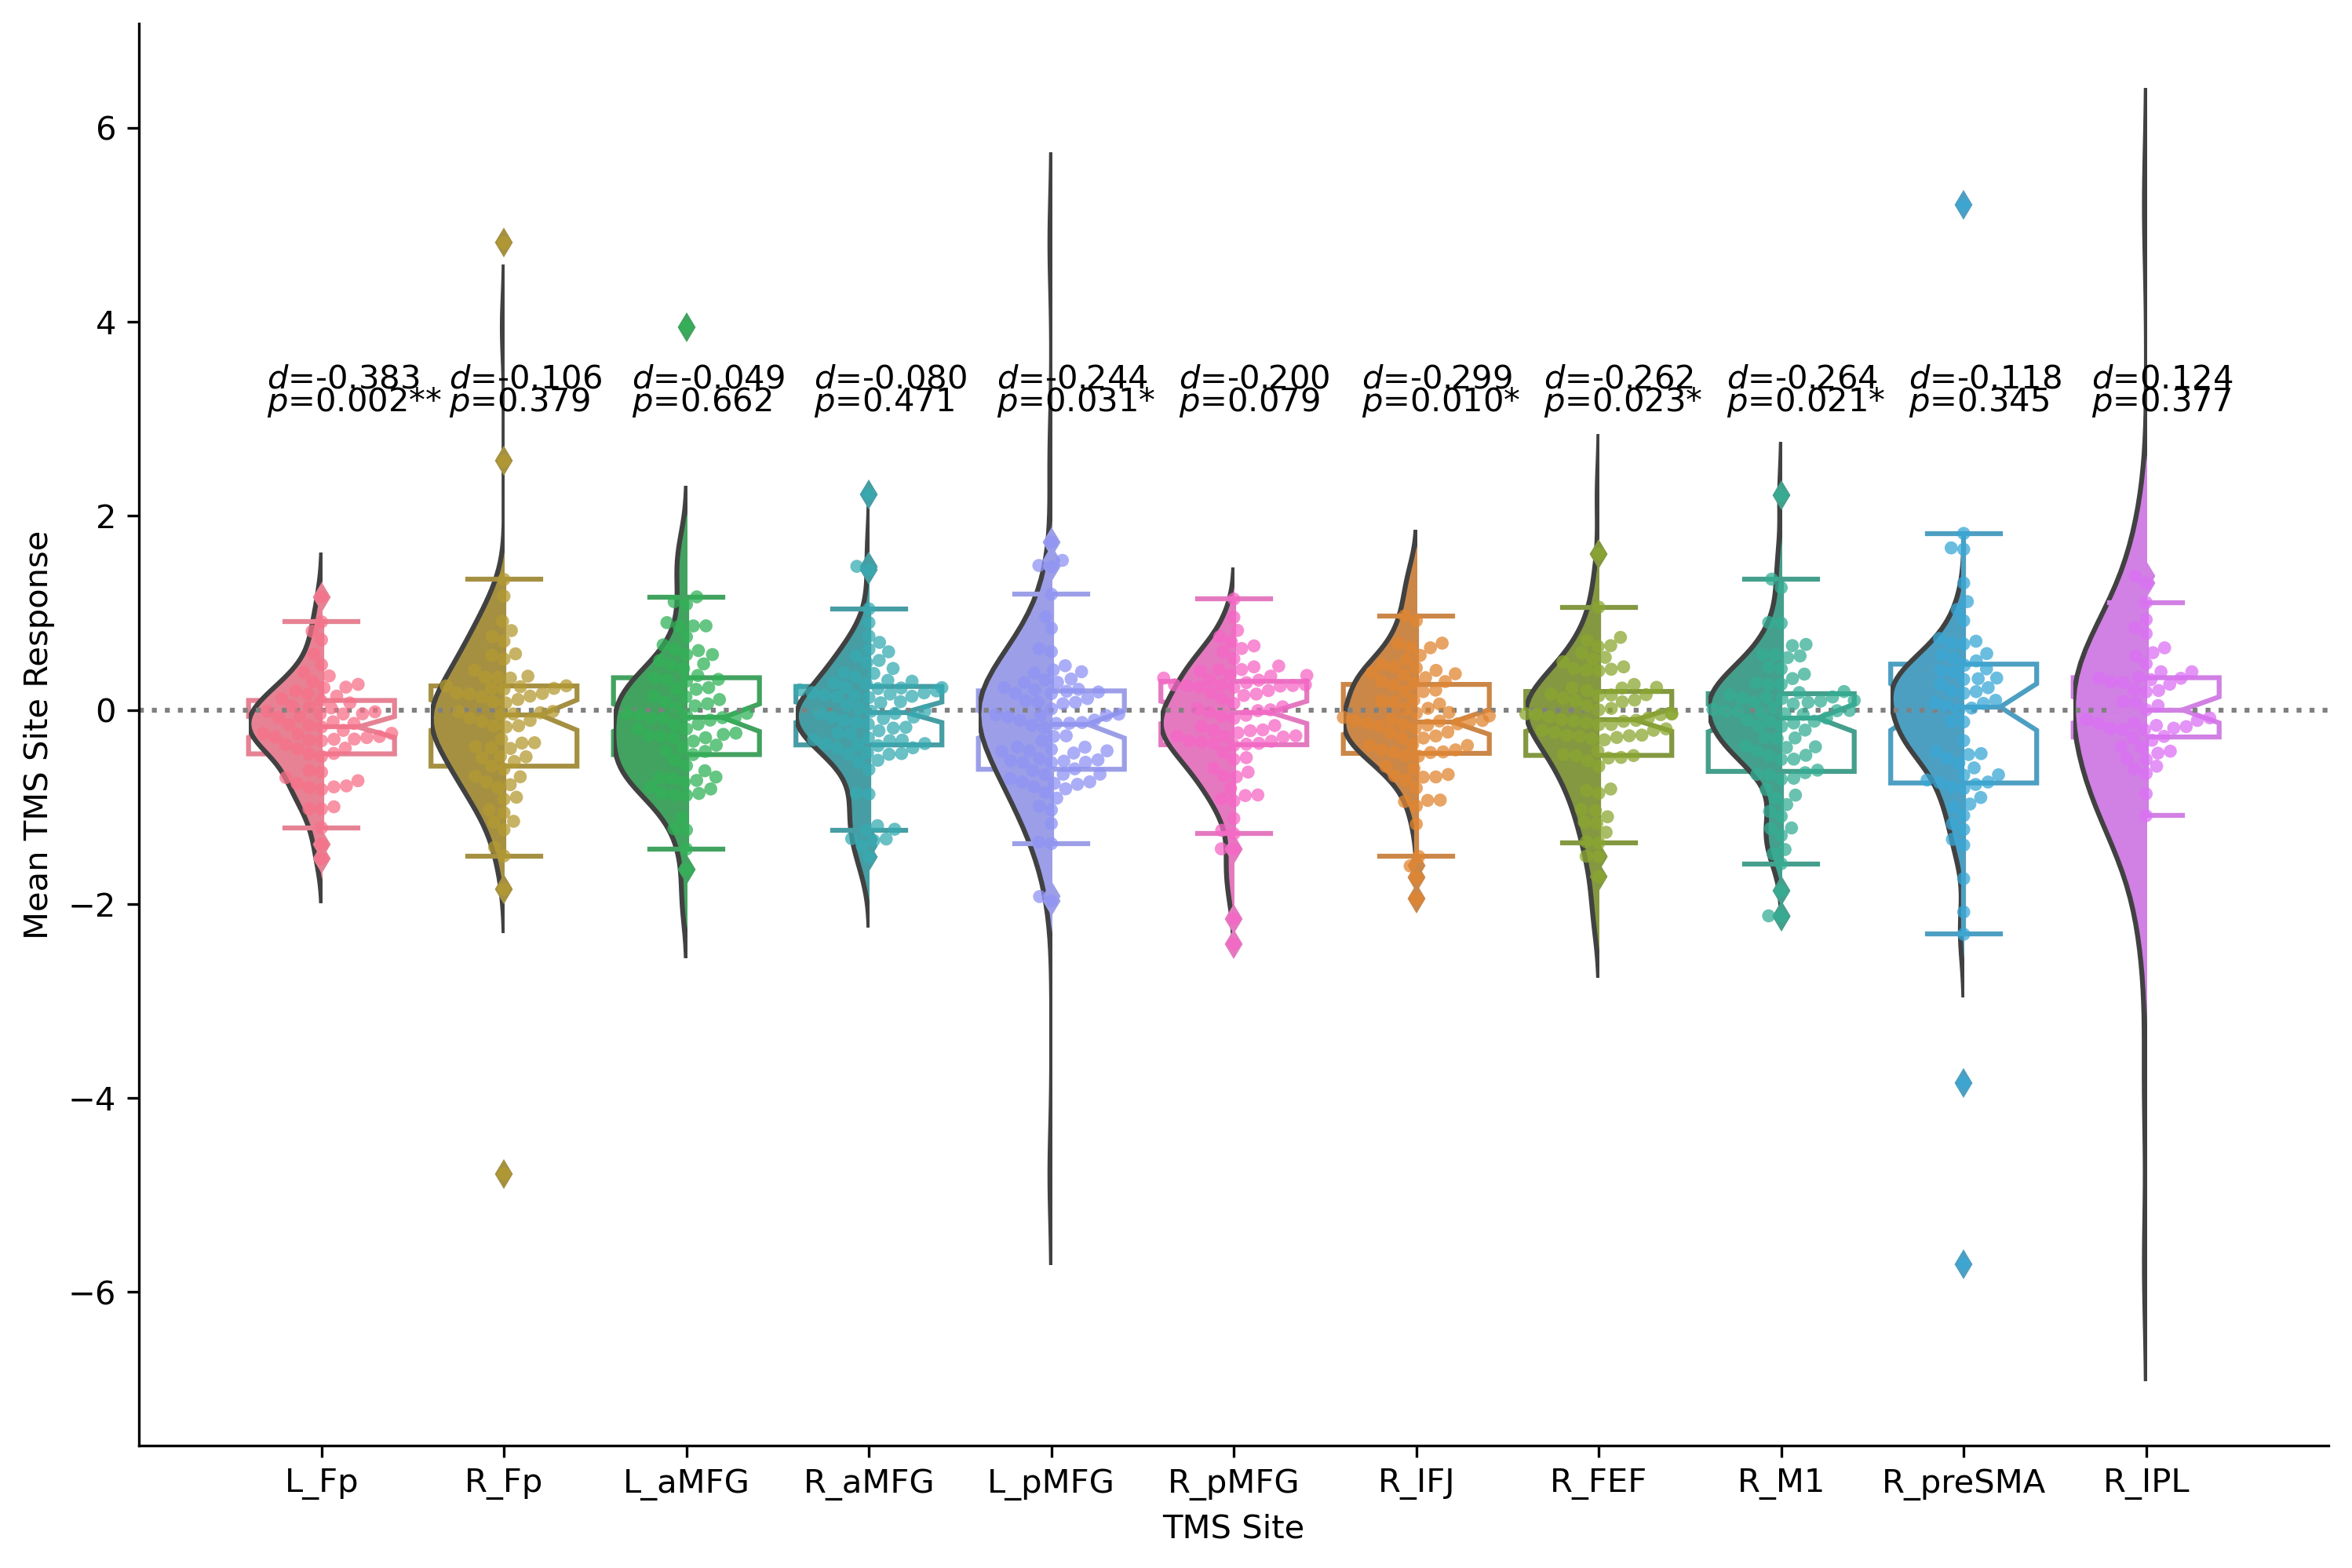

In [12]:
test_variables = ['tms_site_response_6mm',
           'tms_site_response_10mm', 'tms_site_response_14mm', 
           'tms_site_response_14-10mm', 'tms_site_response_10-6mm']

for var in test_variables:
    print(var)
    fig = plot_response(var, result.loc[(var, 'p value'),:], result.loc[(var, "Cohen's d"),:])
    plt.show()
    fig.savefig(out_dir+'/figure1_box_plot_tms_response' + var + '.png', 
                dpi=600, bbox_inches = 'tight', pad_inches = 0.1)
    